Overview of Train_Dataset

First Few Rows of the Dataset:
              Id  OrgId  IncidentId  AlertId                 Timestamp  \
0   180388628218      0         612   123247  2024-06-04T06:05:15.000Z   
1   455266534868     88         326   210035  2024-06-14T03:01:25.000Z   
2  1056561957389    809       58352   712507  2024-06-13T04:52:55.000Z   
3  1279900258736     92       32992   774301  2024-06-10T16:39:36.000Z   
4   214748368522    148        4359   188041  2024-06-15T01:08:07.000Z   

   DetectorId  AlertTitle           Category MitreTechniques   IncidentGrade  \
0           7           6      InitialAccess             NaN    TruePositive   
1          58          43       Exfiltration             NaN   FalsePositive   
2         423         298      InitialAccess           T1189   FalsePositive   
3           2           2  CommandAndControl             NaN  BenignPositive   
4           9          74          Execution             NaN    TruePositive   

   ... ResourceType Roles OSFamily OSVersio

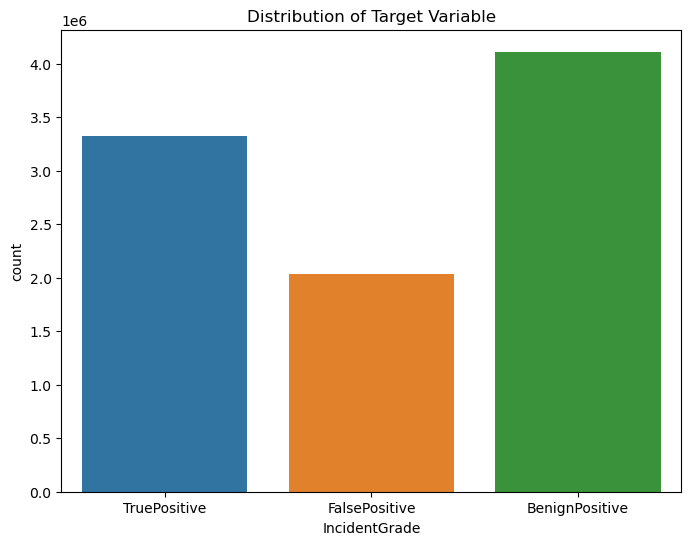

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def optimize_memory(df):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

chunks = []
train_dataset = r"C:\Project_Guvi\Capstone4\GUIDE_Train.csv"
# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(train_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks

# First five rows of the dataset
print("First Few Rows of the Dataset:")
print(df.head())

# shape of the dataset
print("\nShape of the dataset:", df.shape)

# Column names
print("Column Names in the Dataset:")
print(df.columns)

print("\nDataset Information:")
print(df.info())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print("\nNumber of duplicate rows in the dataset:", duplicate_count)

# Target variable distribution
print("\nTarget variable distribution:")
print(df['IncidentGrade'].value_counts())

# plot Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(x=df['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

Data Cleaning and Preprocessing(Train Dataset) 

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

file_path = r"C:\Project_Guvi\Capstone4\GUIDE_Train.csv"

# Read data in chunks and concatenate
chunks = pd.read_csv(file_path, chunksize=500000, low_memory=False)
df = pd.concat(chunks, ignore_index=True)

# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() / len(df) * 100

# List columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values and dropped:")
print(columns_to_drop)

# Drop these columns
df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Impute missing values for numeric columns
numeric_columns = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).columns
for col in numeric_columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

# Impute missing values for categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

# Handling Outliers
def outliers(df, iqr_multiplier=3.0):
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        Q1 = numeric_features[col].quantile(0.25)
        Q3 = numeric_features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR   
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Usage
df = outliers(df, iqr_multiplier=3.0) 

# Feature Engineering
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Hour'] = df['Timestamp'].dt.hour


# Drop the 'Timestamp' column
df.drop(columns=['Timestamp'], inplace=True)

id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 
              'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName', 'CountryCode', 'State', 'City']

# Exclude ID columns from scaling
numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

# Scaling numerical features 
scaler = MinMaxScaler()
df[numeric_features.columns] = scaler.fit_transform(numeric_features)

# Encoding categorical variables
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 
                       'SuspicionLevel', 'MitreTechniques', 'ThreatFamily', 
                       'ResourceType', 'Roles', 'AntispamDirection', 'LastVerdict']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Save 
df.to_csv("C:\Project_Guvi\Capstone4\Train_dataset.csv", index=False)
print("Data preprocessing complete and saved .")


Columns with more than 50% missing values and dropped:
Index(['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId',
       'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection',
       'SuspicionLevel', 'LastVerdict'],
      dtype='object')
Imputed categorical column 'IncidentGrade' with mode value: BenignPositive
Data preprocessing complete and saved .


Overview of Test Dataset

First Few Rows of the Dataset:
              Id  OrgId  IncidentId  AlertId                 Timestamp  \
0  1245540519230    657       11767    87199  2024-06-04T22:56:27.000Z   
1  1400159342154      3       91158   632273  2024-06-03T12:58:26.000Z   
2  1279900255923    145       32247   131719  2024-06-08T03:20:49.000Z   
3    60129547292    222       15294   917686  2024-06-12T12:07:31.000Z   
4   515396080539    363        7615     5944  2024-06-06T17:42:05.000Z   

   DetectorId  AlertTitle           Category                  MitreTechniques  \
0         524         563    LateralMovement      T1021;T1047;T1105;T1569.002   
1           2           2  CommandAndControl                              NaN   
2        2932       10807    LateralMovement  T1021;T1027.002;T1027.005;T1105   
3           0           0      InitialAccess                  T1078;T1078.004   
4          27          18          Discovery                  T1087;T1087.002   

    IncidentGrade  ...       Roles OS

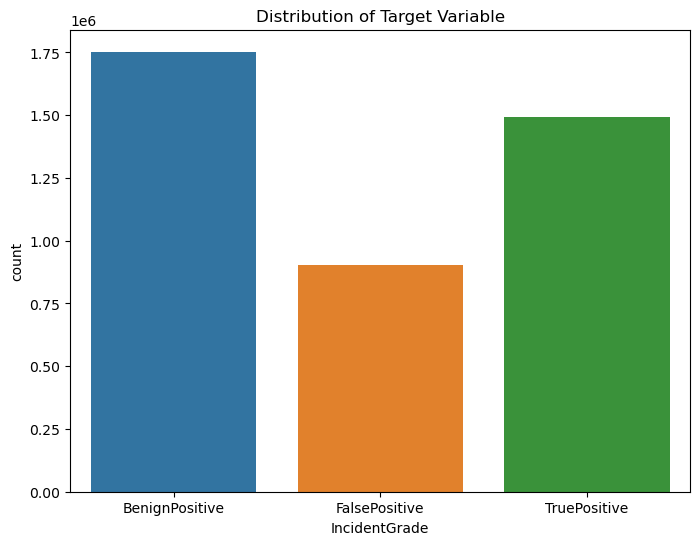

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def optimize_memory(df):
    # Downcast numerical columns
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

chunks = []
train_dataset = r"C:\Project_Guvi\Capstone4\GUIDE_Test.csv"
# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(train_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks

# First Five rows of the dataset
print("First Few Rows of the Dataset:")
print(df.head())

# Shape of the dataset
print("\nShape of the dataset:", df.shape)

# Column names
print("Column Names in the Dataset:")
print(df.columns)

print("\nDataset Information:")
print(df.info())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print("\nNumber of duplicate rows in the dataset:", duplicate_count)

# Target variable distribution
print("\nTarget variable distribution:")
print(df['IncidentGrade'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x=df['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

Date Cleaning and Preprocessing(Test Dataset)

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

file_path = r"C:\Project_Guvi\Capstone4\GUIDE_Test.csv"


# Read data in chunks and concatenate
chunks = pd.read_csv(file_path, chunksize=500000, low_memory=False)
df = pd.concat(chunks, ignore_index=True)

# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() / len(df) * 100

# List columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values and dropped:")
print(columns_to_drop)

# Drop these columns
df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Impute missing values for numeric columns
numeric_columns = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).columns
for col in numeric_columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

# Impute missing values for categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

# Handling Outliers
def outliers(df, iqr_multiplier=3.0):
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        Q1 = numeric_features[col].quantile(0.25)
        Q3 = numeric_features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
            
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Usage
df = outliers(df, iqr_multiplier=3.0)  # Adjusting the IQR multiplier if necessary

# Feature Engineering: Extracting datetime features
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Hour'] = df['Timestamp'].dt.hour


# Drop the 'Timestamp' and 'Usage'column
df.drop(columns=['Timestamp','Usage'], inplace=True)

id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 
              'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName', 'CountryCode', 'State', 'City']

# Exclude ID columns from scaling
numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

# Scaling numerical features
scaler = MinMaxScaler()
df[numeric_features.columns] = scaler.fit_transform(numeric_features)

# Encoding Categorical Variables
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 
                       'SuspicionLevel', 'MitreTechniques', 'ThreatFamily', 
                       'ResourceType', 'Roles', 'AntispamDirection', 'LastVerdict']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Save the process
df.to_csv("C:\Project_Guvi\Capstone4\Test_dataset.csv", index=False)
print("Data preprocessing complete and saved .")


Columns with more than 50% missing values and dropped:
Index(['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId',
       'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection',
       'SuspicionLevel', 'LastVerdict'],
      dtype='object')
Data preprocessing complete and saved .


##### Logistic Regression

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv(r"C:\Project_Guvi\Capstone4\Train_dataset.csv")

X = df.drop('IncidentGrade', axis=1)  # Features
y = df['IncidentGrade']  # Target

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_val)

# Initialize logistic regression
logreg = LogisticRegression(solver='liblinear')

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' is required for l1 penalty
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

# Perform GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_logreg = grid_search.best_estimator_

# Evaluate the best model on validation data
y_pred = best_logreg.predict(X_valid_scaled)

# Print results
print("Best Parameters:")
print(grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters:
{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.58      0.59     14480
           1       0.72      0.58      0.64     17537
           2       0.93      0.96      0.94    129984

    accuracy                           0.88    162001
   macro avg       0.75      0.71      0.73    162001
weighted avg       0.88      0.88      0.88    162001

Confusion Matrix:
[[  8430   2120   3930]
 [  1729  10141   5667]
 [  3906   1763 124315]]


##### Decision Tree Model

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint

# Load the dataset
df = pd.read_csv(r"C:\Project_Guvi\Capstone4\Train_dataset.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_val)

# Initialize Decision Tree Classifier
dtree = DecisionTreeClassifier(random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_distributions = {
    'criterion': ['gini', 'entropy'],  # Measure for quality of split
    'splitter': ['best', 'random'],  # The strategy used to choose the split at each node
    'max_depth': [5, 10, 20, 30, 50],  # Maximum depth of the tree
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20),  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=dtree, param_distributions=param_distributions, 
                                   n_iter=100, scoring='accuracy', cv=5, n_jobs=-1, 
                                   verbose=1, random_state=42)

# Perform RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Get the best model from RandomizedSearchCV
best_dtree = random_search.best_estimator_

# Evaluate the best model on validation data
y_pred = best_dtree.predict(X_valid_scaled)

# Print results
print("Best Parameters:")
print(random_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


Best Parameters:
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 9, 'splitter': 'best'}

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79     14480
           1       0.88      0.88      0.88     17537
           2       0.99      0.97      0.98    129984

    accuracy                           0.95    162001
   macro avg       0.87      0.90      0.88    162001
weighted avg       0.95      0.95      0.95    162001

Confusion Matrix:
[[ 12510   1165    805]
 [  1567  15362    608]
 [  3069    840 126075]]


##### Random Forest Model

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint

# Load dataset
df = pd.read_csv(r"C:\Project_Guvi\Capstone4\Train_dataset.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Random Forest Classifier 
rf = RandomForestClassifier(random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [10, 20,30],  # Maximum depth of each tree
    'min_samples_split': [2, 5],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2],  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2',None],  # Number of features to consider at each split
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
}

# Set up StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Set up RandomizedSearchCV with StratifiedKFold cross-validation
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                      n_iter=20, scoring='f1_macro', cv=cv,
                                      n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV model
random_search_rf.fit(X_train, y_train)

# Get the best model from RandomizedSearchCV
best_rf = random_search_rf.best_estimator_

# Evaluate the best model on validation data
y_pred = best_rf.predict(X_val)

# Print results
print("Best Parameters:")
print(random_search_rf.best_params_)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Best Parameters:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30, 'bootstrap': True}

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     14480
           1       0.97      0.97      0.97     17537
           2       1.00      1.00      1.00    129984

    accuracy                           0.99    162001
   macro avg       0.98      0.98      0.98    162001
weighted avg       0.99      0.99      0.99    162001

Confusion Matrix:
[[ 13992    323    165]
 [   249  17018    270]
 [   186    279 129519]]


##### Gradient Boosting Machines - XGBoost

In [4]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from functools import partial

# Load dataset
df = pd.read_csv(r"C:\Project_Guvi\Capstone4\Train_dataset.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Create a custom fit method with early stopping using partial
fit_with_early_stopping = partial(
    xgb_model.fit,
    early_stopping_rounds=10,         
    eval_set=[(X_val, y_val)],        
    verbose=0                        
)


xgb_model.fit = fit_with_early_stopping

# Define the parameter distribution for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate (eta)
    'max_depth': [3, 6, 9],  # Maximum depth of each tree
    'subsample': [0.7, 0.8, 1.0],  # Subsample ratio of the training instance
    'colsample_bytree': [0.7, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
}

# Set up StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up RandomizedSearchCV with the custom fit method
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=10,  # Number of iterations to sample from param_distributions
    scoring='f1_macro',   # Use F1 macro as the scoring metric
    cv=cv,  # StratifiedKFold for cross-validation
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=1
)

# Fit RandomizedSearchCV with early stopping
random_search.fit(X_train, y_train)

# Get the best model from RandomizedSearchCV
best_xgb = random_search.best_estimator_

# Evaluate the best model on validation data
y_pred = best_xgb.predict(X_val)

# Print the best parameters and evaluation results
print("Best Parameters:")
print(random_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\yuvar\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [07:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters:
{'subsample': 0.8, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 1.0}

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     28960
           1       0.95      0.95      0.95     35073
           2       0.99      0.99      0.99    259968

    accuracy                           0.98    324001
   macro avg       0.95      0.96      0.96    324001
weighted avg       0.98      0.98      0.98    324001

Confusion Matrix:
[[ 26931   1139    890]
 [   971  33341    761]
 [  1347    796 257825]]


In [11]:
import pandas as pd

report = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy':[0.88,0.95,0.99,0.98],
    'Macro-F1 Score':[ 0.73, 0.88, 0.98, 0.96],
    'Precision': [0.75,0.87,0.98,0.95],
    'Recall': [0.71 ,0.90 ,0.98 ,0.96]

}
# Convert to DataFrame
df = pd.DataFrame(report)

# Print comparison table
print("Comparison Table:")
print(df.to_string(index=False))

# Find the best model based on Macro-F1 Score
best_model = df.loc[df['Macro-F1 Score'].idxmax()]

# Print the best model
print("\nBest Model Based on Macro-F1 Score:")
print(best_model)


Comparison Table:
              Model  Accuracy  Macro-F1 Score  Precision  Recall
Logistic Regression      0.88            0.73       0.75    0.71
      Decision Tree      0.95            0.88       0.87    0.90
      Random Forest      0.99            0.98       0.98    0.98
            XGBoost      0.98            0.96       0.95    0.96

Best Model Based on Macro-F1 Score:
Model             Random Forest
Accuracy                   0.99
Macro-F1 Score             0.98
Precision                  0.98
Recall                     0.98
Name: 2, dtype: object


In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from joblib import dump
from scipy.stats import randint

# Load dataset
df = pd.read_csv(r"C:\Project_Guvi\Capstone4\Train_dataset.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data for class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize Random Forest Classifier 
rf = RandomForestClassifier(random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_distributions = {
    'n_estimators': [50,75,100],  # Number of trees in the forest
    'max_depth': [10,15, 20,25],  # Maximum depth of each tree
    'min_samples_split': [2, 5],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2],  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
}

# Set up StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Set up RandomizedSearchCV with StratifiedKFold cross-validation
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                      n_iter=10, scoring='f1_macro', cv=cv,
                                      n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV model 
random_search_rf.fit(X_train_resampled, y_train_resampled)

# Get the best model from RandomizedSearchCV
best_rf = random_search_rf.best_estimator_

# Evaluate the best model on validation data
y_pred = best_rf.predict(X_val)

# Print results
print("Best Parameters:")
print(random_search_rf.best_params_)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Save the best model to a pickle file
model_path = r"C:\Project_Guvi\Capstone4\rf_best_model.pkl"
dump(best_rf, model_path)
print(f"Model saved to {model_path}")


Best Parameters:
{'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25, 'bootstrap': True}

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84     14480
           1       0.90      0.93      0.91     17537
           2       1.00      0.97      0.98    129984

    accuracy                           0.96    162001
   macro avg       0.89      0.94      0.91    162001
weighted avg       0.97      0.96      0.96    162001

Confusion Matrix:
[[ 13392    997     91]
 [  1044  16306    187]
 [  3064    803 126117]]
Model saved to C:\Project_Guvi\Capstone4\rf_best_model.pkl


##### Feature Importance and Error Analysis

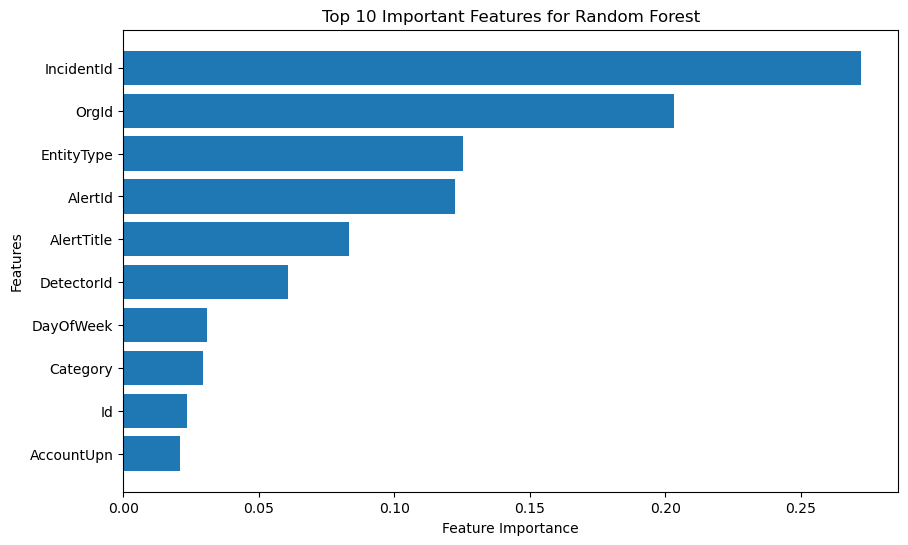

                   Id  OrgId  IncidentId  AlertId  DetectorId  AlertTitle  \
76712   1494648620662    343       65756   446376           6    0.007911   
307513  1640677508781    145       56427    67412           6    0.007911   
723118  1391569407552    136       79434  1339993           7    0.009494   
611047   489626276820    276      171071  1298537           7    0.009494   
182011  1065151894072    560       31417   358336          13    0.017405   

        Category  EntityType  EvidenceRole  DeviceId  ...  ResourceIdName  \
76712          6           6             1     98799  ...            3586   
307513         6           6             1     98799  ...            3586   
723118         6           0             1     98799  ...            3586   
611047         6           0             1     98799  ...            3586   
182011         6           6             1     98799  ...            3586   

        OSFamily  OSVersion  CountryCode  State   City  Year     Month  \


In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from the best Random Forest model
importances = best_rf.feature_importances_

features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot feature importance for top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features for Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

# Identify misclassified samples
misclassified_idx = (y_val != y_pred)

# Extract the misclassified samples
misclassified_samples = X_val[misclassified_idx].copy()

# Display the first 5 misclassified samples
print(misclassified_samples.head(5))

# Evaluate the model's predictions
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


##### Evaluation of Selected Random Forest Model on Test Data

In [33]:
import pandas as pd
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Load the saved Random Forest model
model_path = r"C:\Project_Guvi\Capstone4\rf_best_model.pkl"
best_rf = load(model_path)

# Load the test dataset
test_data_path = r"C:\Project_Guvi\Capstone4\Test_dataset.csv"
test_df = pd.read_csv(test_data_path)

# Separate features and target from test data
X_test = test_df.drop('IncidentGrade', axis=1)  
y_test = test_df['IncidentGrade']

# Make predictions on the test set
y_test_pred = best_rf.predict(X_test)

# Evaluate the model on the test set
print("\nClassification Report on Test Data:")
report = classification_report(y_test, y_test_pred, output_dict=True)
print(classification_report(y_test, y_test_pred))

# Extract macro-F1 score, precision, and recall from the report
macro_f1 = report['macro avg']['f1-score']
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']

print("\nMacro-F1 Score: {:.2f}".format(macro_f1))
print("Macro Precision: {:.2f}".format(macro_precision))
print("Macro Recall: {:.2f}".format(macro_recall))

# Confusion Matrix
print("\nConfusion Matrix on Test Data:")
print(confusion_matrix(y_test, y_test_pred))



Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.64      0.93      0.76     30543
           1       0.86      0.82      0.84     35932
           2       1.00      0.96      0.98    310354

    accuracy                           0.94    376829
   macro avg       0.83      0.90      0.86    376829
weighted avg       0.95      0.94      0.94    376829


Macro-F1 Score: 0.86
Macro Precision: 0.83
Macro Recall: 0.90

Confusion Matrix on Test Data:
[[ 28370   2036    137]
 [  5110  29570   1252]
 [ 10898   2814 296642]]
